In [19]:
from __future__ import division
import glob
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd

from mpl_toolkits.basemap import Basemap

import statsmodels.api as sm

import seaborn as sns

%matplotlib inline

In [2]:
date_parser = lambda x: datetime.strptime(x, '%Y%m%d')

ID_VARS = ['Station', 'Komponente', 'Datum', 'TYPE_OF_AREA', 'TYPE_OF_STATION', 'TYPE_OF_DATA', 'Lieferung']
VALUES = ['Wert{:02d}'.format(i) for i in range(1, 25)]
date_format = "%Y%m%d %H"

def get_dataframe():
    for filename in glob.glob('data/DE*.csv'):
        print filename
        df = pd.read_csv(filename, encoding='latin1', sep=';', quotechar="'", na_values=['', '-999', '-111'], parse_dates=[2], date_parser=date_parser)
        df = pd.melt(df, id_vars=ID_VARS, value_vars=VALUES, var_name='hour', value_name='value')
        df['hour'] = df.hour.str.replace('Wert', '').convert_objects(convert_numeric=True) - 1
        df['date'] = pd.to_datetime(df.Datum.apply(lambda x: x.strftime('%Y%m%d')) + ' ' + df.hour.apply(str), format=date_format)
        df = df.drop(['Datum', 'hour'], axis=1)
        yield df

df = pd.concat(get_dataframe())
df.head()

data/DE2009NO2_1SMW_20150810.csv
data/DE2010NO2_1SMW_20150810.csv
data/DE2011NO2_1SMW_20150810.csv
data/DE2012NO2_1SMW_20150810.csv
data/DE2013NO2_1SMW_20150810.csv
data/DE2014NO2_1SMW_20150810.csv
data/DE2015NO2_1SMW_20150810.csv


,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value,date
0,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,23.20,2009-01-01
1,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,25.80,2009-01-02
2,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,17.65,2009-01-03
3,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,NaN,2009-01-04
4,DEBB007,Stickstoffdioxid,vorstädtisches Gebiet,Hintergrund,H,Y,19.20,2009-01-05


In [3]:
german_date_parser = lambda x: datetime.strptime(x, '%d.%m.%Y')
stations = pd.read_csv('data/station_All.csv', encoding='latin1', sep=';', quotechar='"', skiprows=1, parse_dates=[4, 5], date_parser=german_date_parser)
stations[u'Aktivitätsperiode: bis'] = stations[u'Aktivitätsperiode: bis'].convert_objects(convert_dates='coerce')
stations[u'lng'] = stations[u'Länge dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations[u'lat'] = stations[u'Breite dezimal'].str.replace(',', '.').convert_objects(convert_numeric=True)
stations['height'] = stations[u'Höhe'].convert_objects(convert_numeric=True)
stations['ags'] = stations[u'Amtlicher Gemeindeschlüssel (AGS)'].dropna().apply(lambda x: '{:0>5d}'.format(int(str(x)[:5])))
stations = stations.rename(columns={'Stationscode': 'Station'})
stations.head()

,Station,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,Nr,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
0,DEBB001,Burg (Spreewald),Luftmessstation,BUCH,1993-01-01,1993-01-01,2003-05-19,nein,Bahnhofstr.,9,...,no,"3,5","3,5",NaN,k.A.,NaN,14.141703,51.837590,54,12071
1,DEBB002,Brandenburg-Nord,Luftmessstation,BRGU,1991-02-01,1991-02-01,1994-06-30,nein,GutsMuthsstraße,NaN,...,no,"3,5",NaN,NaN,k.A.,NaN,12.560379,52.420960,31,12051
2,DEBB003,Brandenburg a.d. Havel,Luftmessstation,BRPI,1991-03-01,1991-03-01,2001-07-06,nein,Gertrud-Pieter-Platz,9,...,1A3,"3,5","3,5",NaN,k.A.,NaN,12.544441,52.412114,33,12051
3,DEBB004,Cottbus-LUA,Luftmessstation,COUA,1991-01-01,1991-01-01,2003-12-31,nein,Am Nordrand,45,...,no,"3,5",NaN,NaN,k.A.,NaN,14.327692,51.778045,68,12052
4,DEBB005,Cottbus-City (-Mitte),Luftmessstation,COCY,1991-01-01,1991-01-01,1997-03-31,nein,Karl-Liebknecht-Str.,136,...,no,"3,5","3,5",NaN,k.A.,NaN,14.331685,51.757900,74,12052


In [4]:
bbox = {
  'lon': 10.45415,
  'lat': 51.164181,
  'll_lon': 5.86624,
  'll_lat': 47.27021,
  'ur_lon': 15.04205,
  'ur_lat': 55.05814
}

def plot_map(df, vals=None):
    markersize = 40
    markertype = 'o'  # pixel
    markercolor = '#325CA9'  # blue
    if vals is not None:
        markercolor = df[vals].as_matrix()
    markeralpha = .75 #  a bit of transparency

    fig = plt.figure(figsize=(10,16))
    m = Basemap(
      projection='mill', lon_0=bbox['lon'], lat_0=bbox['lat'],
      llcrnrlon=bbox['ll_lon'], llcrnrlat=bbox['ll_lat'],
      urcrnrlon=bbox['ur_lon'], urcrnrlat=bbox['ur_lat'],
      resolution='l'
    )
    m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
    x, y = m(df.lng.as_matrix(), df.lat.as_matrix())
    m.drawcoastlines()
    m.drawcountries()
    m.scatter(x, y, markersize, marker=markertype,  cmap='cool', c=markercolor, alpha=markeralpha)
    m.colorbar()
    return m

    

In [5]:
df.TYPE_OF_AREA.value_counts()

städtisches Gebiet       14713392
vorstädtisches Gebiet     5046072
ländliches Gebiet         2017080
ländlich regional         1600992
ländlich stadtnah          943920
ländlich abgelegen         368568
dtype: int64

In [6]:
df.TYPE_OF_STATION.value_counts()

Hintergrund    14944800
Verkehr         8298312
Industrie       1446912
dtype: int64

## Map of all stations coloured by their median measurement 2015

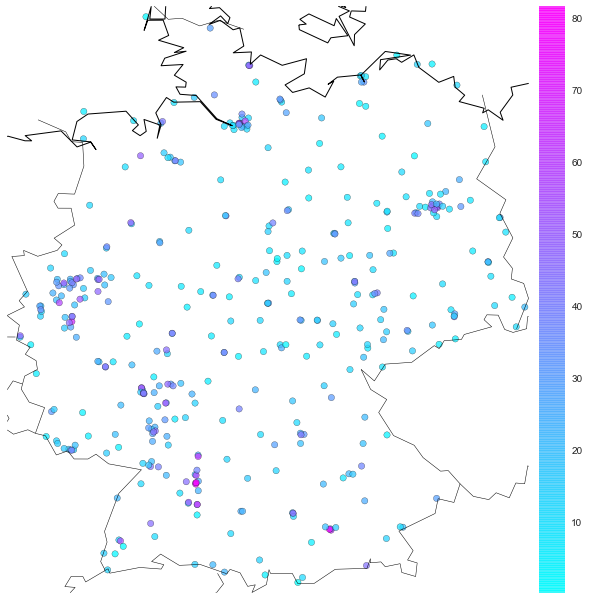

In [20]:
filtered = df[df.date.dt.year == 2015]
filtered = filtered.set_index('date')
filtered = filtered.groupby('Station')
filtered = filtered.value.median().reset_index()
filtered = filtered.merge(stations, on='Station')
plot_map(filtered, 'value')

## All stations with their 2015 median value greater than 50.

That means that half of all measurements in 2015 were greater than 50!

In [8]:
filtered[filtered.value > 50]

,Station,value,Stationsname,Kategorie,Synonym,Aktiv seit,Aktivitätsperiode: von,Aktivitätsperiode: bis,Verlegt,Straße,...,Quelle 1 (Hauptquelle) - ID,Gasförmige Schadstoffe,Partikelförmige Schadstoffe,Deposition,Umweltmonitoring-Typ,Unnamed: 44,lng,lat,height,ags
36,DEBE064,50.865000,B Neukölln-Karl-Marx-Str. 76,Luftmessstation,NaN,1993-08-01,1993-08-01,NaT,nein,Karl-Marx-Str.,...,1A3,"2,3","3,5",NaN,k.A.,NaN,13.433967,52.481709,40,11000
71,DEBW099,60.000000,Stuttgart_Arnulf-Klett-Platz,Luftmessstation,NaN,1994-12-06,1994-12-06,NaT,nein,Arnulf-Klett-Platz,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.180720,48.783130,244,81110
74,DEBW116,73.000000,Stuttgart Hohenheimer Straße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Hohenheimer Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.184490,48.768710,302,81110
75,DEBW117,58.000000,Ludwigsburg Friedrichstraße (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Friedrichstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.190030,48.889200,299,81180
76,DEBW118,80.000000,Stuttgart Am Neckartor (S),Luftmessstation,NaN,2003-12-23,2003-12-23,NaT,NaN,Am Neckartor,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.191010,48.788100,239,81110
79,DEBW122,55.000000,Freiburg Schwarzwaldstraße (V),Luftmessstation,NaN,2004-12-27,2004-12-27,NaT,NaN,Schwarzwaldstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,7.859920,47.988200,289,83110
81,DEBW136,52.000000,Tübingen Mühlstraße (S),Luftmessstation,NaN,2004-01-01,2004-01-01,NaT,NaN,Mühlstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.058020,48.520230,340,84160
82,DEBW147,68.000000,Reutlingen Lederstraße Ost (S),Luftmessstation,NaN,2007-03-21,2007-03-21,NaT,NaN,Lederstraße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.210790,48.489330,382,84150
83,DEBW152,63.000000,Heilbronn Weinsberger Straße Ost (S),Luftmessstation,NaN,2009-01-01,2009-01-01,NaT,NaN,Weinsberger Straße,...,1A3,"3,5","3,5",NaN,k.A.,NaN,9.225890,49.146000,165,81210
101,DEBY037,62.840000,München/Stachus,Luftmessstation,NaN,1978-01-01,1978-01-01,NaT,nein,Sonnenstraße,...,1A3,"3,8","4,5",NaN,k.A.,NaN,11.564924,48.137252,521,91620


## Top 20 highest measurements in dataset

"DENW116" (Krefeld (Hafen), Luftmessstation) seems to be a pretty bad area (Geo: 51.342561, 6.670195)

In [9]:
df.sort_index(by='value', ascending=False).head(20)

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value,date
99821,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1346.706000,2012-09-26 00:00:00
882586,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1294.062000,2012-09-26 05:00:00
3700539,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1275.116000,2012-09-25 23:00:00
256374,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1206.955000,2012-09-26 01:00:00
569480,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,1088.394000,2012-09-26 03:00:00
726033,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,987.990000,2012-09-26 04:00:00
1039139,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,985.045000,2012-09-26 06:00:00
412928,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,900.788000,2012-09-27 02:00:00
3387433,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,879.932000,2012-09-25 21:00:00
256375,DENW116,Stickstoffdioxid,vorstädtisches Gebiet,Industrie,S,Y,875.983000,2012-09-27 01:00:00


## Cross-checking

[This report](http://www.umweltbundesamt.de/sites/default/files/medien/358/dokumente/no2_2014_0.pdf) contains Jahresmittelwert and number of occasions when Stundenmittelwerte exceeded 200. Cross-checking some values from the table.

In [10]:
filtered = df[(df.Station == 'DEBW152') & (df.date.dt.year == 2014)]
filtered.value.mean()

65.087167070217916

In [11]:
filtered[filtered.value > 200]

,Station,Komponente,TYPE_OF_AREA,TYPE_OF_STATION,TYPE_OF_DATA,Lieferung,value,date
1232796,DEBW152,Stickstoffdioxid,städtisches Gebiet,Verkehr,S,Y,219,2014-11-03 08:00:00
